In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import thư viện

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Import Label File

In [ ]:
label_data = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()

In [ ]:
#Tổng số các video
len(label_data)

# Setting đường dẫn từ data

In [ ]:
path=[]
for label in label_data.labels.values:
    path.append('../input/ucf101/UCF101/UCF-101/'+label+"/")
path[0]

# Data Preperation

In [ ]:
#Function for Feature Extraction
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=10
    frames_list=[]
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        if not ret:
            break;
        #Resize the image
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        #Append to the frame
        frames_list.append(frame)
    video_reader.release()
    #Return the Frames List
    return frames_list

The below function is used for extracting features from a video file. It takes in the path of the video file as input and returns a list of frames from the video.

The function first reads the video using the cv2.VideoCapture method. It then calculates the total number of frames in the video using the cv2.CAP_PROP_FRAME_COUNT property. Next, it calculates the interval after which frames will be added to the list by dividing the total number of frames by the desired sequence length. This is done to ensure that we only extract a certain number of frames from the video.

The function then iterates through the video frames and sets the current frame position using the cv2.CAP_PROP_POS_FRAMES property. It then reads the current frame and resizes it to a desired width and height using the cv2.resize method. The frame is then normalized by dividing it by 255. Finally, the frame is appended to the frames_list.

Once all the desired frames have been extracted, the function releases the video reader and returns the frames_list.

For example, if we pass a video file with 100 frames and a sequence length of 10 to this function, it will extract frames at intervals of 10 (0th, 10th, 20th, ... 90th frame) and return a list of 10 frames.


Why we need sequence length?
Sequence length is the number of frames that we want to extract from a video file. It is an important parameter in feature extraction as it determines the number of frames that will be used to represent the video.

There are several reasons why we might want to specify a particular sequence length:

Memory Constraints: Extracting all the frames from a video file can be computationally expensive and may not be feasible if we have limited memory or processing power. By specifying a sequence length, we can reduce the number of frames that need to be processed and stored in memory, making the feature extraction process more efficient.

Length of Video: Some videos may be very long and contain thousands of frames. In such cases, it may not be necessary or practical to extract all the frames for feature extraction. By specifying a sequence length, we can reduce the number of frames that need to be processed, making the feature extraction process more efficient.

Relevance of Frames: Not all frames in a video may be relevant for feature extraction. By specifying a sequence length, we can ensure that only the most relevant frames are extracted, which can improve the quality of the features.

Overall, sequence length is an important parameter in feature extraction as it helps us to balance the trade-off between the amount of information extracted from the video and the computational resources required to process it.






In [ ]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

The above function is used to load and process video files and store them in a dataset. It takes in a list of datasets (folders containing video files) as input and returns a tuple of images (a numpy array of extracted frames) and labels (a numpy array of label indices).

The function first initializes two empty lists: labels and images. It then iterates through each folder in the datasets list, which corresponds to a particular category of videos. For each folder, it iterates through all the video files and gets the path name of each video using the os.path.join method.

It then calls the feature_extraction function to extract the frames of the current video and stores the resulting list in the images list. It also appends the label index (which corresponds to the category of the video) to the labels list.

Once all the videos have been processed, the function returns the images and labels as a tuple.

For example, if we pass a list of two datasets (folders) containing 10 video files each to this function, it will extract the frames from all 20 videos, store them in the images list, and append the corresponding label indices (0 or 1) to the labels list. It will then return a tuple of numpy arrays containing the extracted frames and the label indices.

In [ ]:
#Use the first 10 video classes for training the model for demonstration.
images, labels = load_video(path[:9])


In [ ]:
#Shapes
images.shape, pd.Series(labels).shape

In [ ]:
#Train Test Split
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

## Mô hình: CNN + LSTM (ConvLSTM2D)

![](https://i.stack.imgur.com/iYmhu.png)


In [ ]:
model = Sequential()

model.add(BatchNormalization(momentum=0.8, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(Flatten())

model.add(Dense(4096,activation="relu"))
    
model.add(Dense(9, activation='softmax'))
model.summary()

mô hình Convolutional Long Short-Term Memory (ConvLSTM) cho phân loại video. Bao gồm một số lớp ConvLSTM2D, MaxPooling3D, Dropout, BatchNormalization và Dense.

Đầu vào của mô hình là một dãy các khung hình video có dạng (batch_size, sequence_length, height, width, channels). Lớp đầu tiên là một lớp BatchNormalization, nó chuẩn hóa dữ liệu đầu vào sử dụng trung bình và độ lệch chuẩn của batch

Tiếp theo là lớp ConvLSTM2D, là một loại lớp mạng neural convolutional (CNN) có ô nhớ để xử lý dữ liệu tuần tự. Các lớp này áp dụng bộ lọc convolutional cho dữ liệu đầu vào và sử dụng thuật toán LSTM để xử lý thông tin tuần tự. Tham số kernel_size xác định kích thước của bộ lọc convolutional, và tham số activation xác định hàm kích hoạt được sử dụng. Tham số return_sequences xác định xem kết quả của lớp có được trả về như một dãy hay là một kết quả đầu ra duy nhất. Tham số recurrent_dropout xác định tỷ lệ dropout cho các kết nối tuần tự trong lớp.

Các lớp MaxPooling3D được sử dụng để giảm mẫu dữ liệu đầu vào bằng cách lấy giá trị lớn nhất qua một cửa sổ giảm mẫu của kích thước đã chỉ định. Tham số padding xác định xem dữ liệu đầu vào có được lấp đầy trước khi áp dụng thao tác giảm mẫu.

Các lớp TimeDistributed được sử dụng để áp dụng một lớp cho mỗi bước của một dãy độc lập. Các lớp Dropout được sử dụng để đặt ngẫu nhiên một phần của đơn vị đầu vào thành 0 tại mỗi lần cập nhật trong quá trình huấn luyện, điều này giúp ngăn ngừa overfitting.

Các lớp BatchNormalization được sử dụng để chuẩn hóa các hoạt động của các lớp trước sử dụng trung bình và độ lệch chuẩn của batch.

Cuối cùng, mô hình có một lớp Flatten để làm phẳng kết quả của lớp trước, theo sau là hai lớp Dense. Lớp dense đầu tiên có 4096 đơn vị và sử dụng hàm kích hoạt ReLU. Lớp dense thứ hai có 9 đơn vị và sử dụng hàm kích hoạt softmax, được thích hợp cho các tác vụ phân loại. Hàm softmax sẽ đưa ra một phân bố xác suất qua 9 lớp có thể, cho phép mô hình dự đoán lớp có xác suất cao nhất.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
#Train model
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Xác định một hàm callback EarlyStopping cho quá trình huấn luyện mô hình. Hàm callback EarlyStopping giám sát mất mát xác nhận và dừng quá trình huấn luyện khi mất mát xác nhận không cải thiện trong số vài epoch.

Tham số monitor xác định số lượng cần giám sát. Trong trường hợp này, đó là mất mát xác nhận. Tham số patience xác định số epoch để chờ trước khi dừng quá trình huấn luyện nếu mất mát xác nhận không cải thiện. Tham số mode xác định số lượng được giám sát có nên được tối thiểu hoặc tối đa. Tham số restore_best_weights xác định trọng lượng của mô hình có nên được khôi phục lại trọng lượng tốt nhất (mất mát xác nhận thấp nhất) sau khi quá trình huấn luyện đã dừng.

Ví dụ, nếu chúng ta sử dụng hàm callback EarlyStopping này trong quá trình huấn luyện một mô hình, nó sẽ giám sát mất mát xác nhận tại mỗi epoch và dừng quá trình huấn luyện nếu mất mát xác nhận không cải thiện trong 5 epoch. Nếu tham số restore_best_weights được đặt là True, nó cũng sẽ khôi phục trọng lượng của mô hình về trọng lượng tốt nhất (mất mát xác nhận thấp nhất) sau khi quá trình huấn luyện đã dừng.

In [ ]:
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

In [ ]:
accuracy_score(y_test, predicted_classes)

In [ ]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

In [ ]:
model.save('CNN_LSTM_Model.h5')

Vẽ ma trận nhầm lẫn cho phân loại. Nó nhận vào nhãn thật (y_test) và nhãn dự đoán (predicted_classes) làm đầu vào và vẽ ma trận có kích thước (số lớp) x (số lớp).

Ma trận nhầm lẫn là một ma trận cho thấy số lượng các dự đoán đúng và sai cho mỗi lớp. Các hàng của ma trận đại diện cho nhãn thật, và các cột đại diện cho nhãn dự đoán. Một ô (i, j) trong ma trận đại diện cho số lượng trường hợp với nhãn thật i và nhãn dự đoán j.

Sử dụng hàm confusion_matrix từ thư viện sklearn để tính ma trận nhầm lẫn. 

Sau đó, sử dụng hàm imshow từ matplotlib để vẽ ma trận nhầm lẫn dưới dạng hình ảnh. 

Cuối cùng, sử dụng hàm itertools.product để lặp qua các phần tử của ma trận và thêm giá trị tương ứng vào mỗi ô bằng hàm text.

Ví dụ, nếu chúng ta truyền một danh sách nhãn thật [0, 1, 0, 2, 1] và một danh sách nhãn dự đoán [0, 1, 0, 2, 2] cho mã này, nó sẽ vẽ:

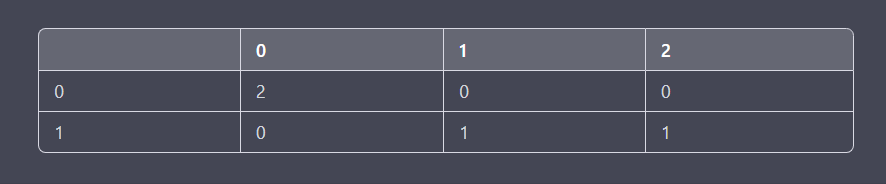


## Mô hình: CNN (Conv2D)

In [ ]:
model = Sequential()

model.add(BatchNormalization(momentum=0.8, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last'))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last'))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last'))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last'))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(Flatten())

model.add(Dense(4096,activation="relu"))
    
model.add(Dense(9, activation='softmax'))
model.summary()

Một số lớp Conv2D, MaxPooling3D, Dropout và Dense.

Đầu vào của mô hình là một chuỗi các khung hình video có hình dạng (batch_size, sequence_length, height, width, channels). 
Tầng đầu tiên BatchNormalization, lớp này chuẩn hóa dữ liệu đầu vào bằng cách sử dụng giá trị trung bình và độ lệch chuẩn.

Nhiều lớp Conv2D, đó là một loại lớp CNN áp dụng bộ lọc tích chập cho dữ liệu đầu vào. Tham số kernel_size xác định kích thước của bộ lọc tích chập, và tham số activation xác định hàm kích hoạt sẽ được sử dụng.

Lớp MaxPooling3D được sử dụng để giảm mẫu dữ liệu đầu vào bằng cách lấy giá trị lớn nhất trên cửa sổ lấy mẫu của kích thước đã chỉ định. Tham số padding xác định liệu dữ liệu đầu vào có được lấp chừa trước khi áp dụng hoạt động lấy mẫu.

Lớp TimeDistributed được sử dụng để áp dụng một lớp cho mỗi bước của một dãy độc lập. Lớp Dropout được sử dụng để đặt ngẫu nhiên một phần của đơn vị đầu vào thành 0 tại mỗi lần cập nhật trong quá trình huấn luyện, điều này giúp ngăn chặn quá huấn luyện.

Cuối cùng, mô hình có một lớp Flatten để phẳng hóa đầu ra của lớp trước, sau đó là hai lớp Dense. Lớp dense đầu tiên có 4096 đơn vị và sử dụng hàm kích hoạt ReLU. Lớp dense thứ hai có 9 đơn vị và sử dụng hàm kích hoạt softmax, đó là phù hợp cho nhiệm vụ phân loại. Tóm tắt mô hình sau đó được in ra để hiển thị chi tiết của mô hình.

In [ ]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
#Model training
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=64, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

In [ ]:
#Vẽ biểu đồ để kiểm tra độ chính xác của tập train và tập test trong khoảng thời gian
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

In [ ]:
#Test Accuracy
accuracy_score(y_test, predicted_classes)

In [ ]:
model.save('CNN_Model.h5')

In [ ]:
accuracy_score(y_test, predicted_classes)